In [ ]:
pip install kagglehub scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
import urllib.request
import tarfile
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import load_files


In [5]:
def generate_large_data(n=3000, d=10000):
    centers = np.random.standard_normal((5, d)) * 10
    X = []
    for center in centers:
        cluster_points = center + np.random.standard_normal((n // 5, d))
        X.append(cluster_points)
    return np.vstack(X)

def benchmark_hyperparameter_k(X, ax=None, dataset_name="Data"):
    n_samples, d_features = X.shape

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    start = time.time()
    # ground truth
    dist_matrix_orig = euclidean_distances(X, squared=True)
    mask = np.triu_indices(n_samples, k=1)
    distances_orig = dist_matrix_orig[mask]

    valid_idx = distances_orig > 1e-9
    distances_orig = distances_orig[valid_idx]

    all_k_values = [100, 500, 1000, 2000, 4000]
    k_values = [k for k in all_k_values if k < d_features]
    if not k_values: k_values = [d_features // 2]

    results = {}

    print(f"\n--> Start testing {dataset_name} (Dim: {d_features}):")

    for k in k_values:
        print(f"   Testing k = {k} ...", end=" ")

        rp = GaussianRandomProjection(n_components=k, random_state=42)

        t0 = time.time()
        X_new = rp.fit_transform(X)
        t_proj = time.time() - t0

        dist_matrix_new = euclidean_distances(X_new, squared=True)
        distances_new = dist_matrix_new[mask][valid_idx]

        ratios = distances_new / distances_orig
        results[k] = ratios

        # draw
        sns.kdeplot(ratios, label=f'k={k} ({t_proj:.2f}s)', ax=ax, fill=True, alpha=0.1)
        print(f"Done. Mean: {np.mean(ratios):.4f}, Std: {np.std(ratios):.4f}")

    ax.axvline(x=1.0, color='black', linestyle='--')
    ax.set_title(f'Distortion: {dataset_name}')
    ax.set_xlabel('Deformation ratio')
    ax.set_ylabel('Density')
    ax.set_xlim(0.5, 1.5)
    ax.legend(fontsize='small')
    ax.grid(True, alpha=0.3)

    return results

def plot_error_trend(results, ax=None, dataset_name="Data"):
    if results is None or len(results) == 0:
        print("No data!")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    k_values = sorted(results.keys())
    std_devs = [np.std(results[k]) for k in k_values]

    # lab
    ax.plot(k_values, std_devs, 'o-', linewidth=2, label='Lab (Std)')

    # Theory (1/sqrt(k))
    theoretical = [std_devs[0] * np.sqrt(k_values[0]) / np.sqrt(k) for k in k_values]
    ax.plot(k_values, theoretical, 'r--', label=r'Theoretical ($1/\sqrt{k}$)')

    ax.set_title(f'Error Trend: {dataset_name}')
    ax.set_xlabel('Target dimensions (k)')
    ax.set_ylabel('Standard deviation')
    ax.grid(True)
    ax.legend()

**Abation**


--> Start testing Synthetic (Dim: 10000):
   Testing k = 100 ... Done. Mean: 1.0835, Std: 0.1261
   Testing k = 500 ... Done. Mean: 1.0563, Std: 0.0596
   Testing k = 1000 ... Done. Mean: 1.0514, Std: 0.0503
   Testing k = 2000 ... Done. Mean: 1.0257, Std: 0.0268
   Testing k = 4000 ... Done. Mean: 1.0128, Std: 0.0193


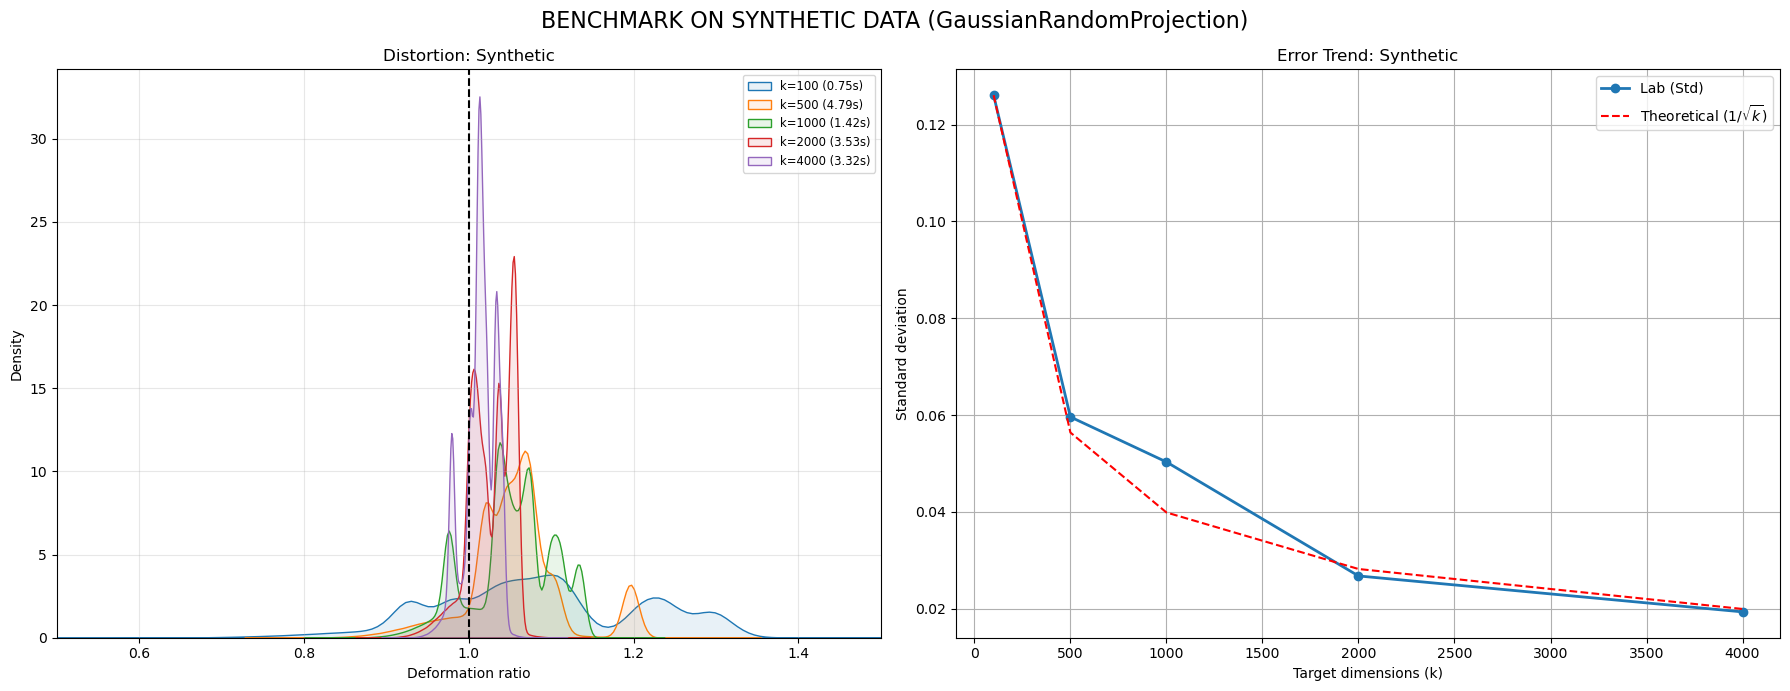

In [7]:
if __name__ == "__main__":
    # create data
    X_huge = generate_large_data(n=3000, d=10000)

    # frame
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    plt.suptitle("BENCHMARK ON SYNTHETIC DATA (GaussianRandomProjection)", fontsize=16)

    # run benchmark
    results_data = benchmark_hyperparameter_k(X_huge, ax=ax1, dataset_name="Synthetic")

    # plot trend
    plot_error_trend(results_data, ax=ax2, dataset_name="Synthetic")

    plt.tight_layout()
    plt.show()

**Evaluation**

In [ ]:
## for GG Colab
## <= 1000
# df_mnist = kagglehub.dataset_load(
#     KaggleDatasetAdapter.PANDAS,
#     "oddrationale/mnist-in-csv",
#     "mnist_train.csv"
# )
# df_mnist = df_mnist.iloc[:, 1:].values.astype(np.float32)
# df_mnist /= 255.0 
# print(df_mnist.shape)

## <= 10,000
# df_ecommerce = kagglehub.dataset_load(
#     KaggleDatasetAdapter.PANDAS,
#     "carrie1/ecommerce-data",
#     "data.csv",
#     pandas_kwargs={
#         "encoding": "latin1"
#     }
# )
# df_clean = df_ecommerce.dropna(subset=['Description'])
# descriptions = df_clean['Description'].astype(str)
# vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
# X_ecommerce = vectorizer.fit_transform(descriptions)

# print(X_ecommerce.shape)

## > 10,000
# !wget -q http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
# !tar -xzf 20news-bydate.tar.gz

# newsgroups_train = load_files('20news-bydate-train', encoding='latin-1')
# vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
# X_high_dim = vectorizer.fit_transform(newsgroups_train.data)

# print(X_high_dim.shape)

In [10]:
# <= 1000
path_mnist_folder = kagglehub.dataset_download("oddrationale/mnist-in-csv")
csv_path_mnist = os.path.join(path_mnist_folder, "mnist_train.csv")

try:
    df_mnist = pd.read_csv(csv_path_mnist)
    df_mnist = df_mnist.iloc[:, 1:].values.astype(np.float32)
    df_mnist /= 255.0 
    print("MNIST Shape:", df_mnist.shape)
except Exception as e:
    print(f"Error read MNIST: {e}")


# <= 10,000
path_ecommerce_folder = kagglehub.dataset_download("carrie1/ecommerce-data")
csv_path_ecom = os.path.join(path_ecommerce_folder, "data.csv")

try:
    df_ecommerce = pd.read_csv(csv_path_ecom, encoding="ISO-8859-1")
    
    df_clean = df_ecommerce.dropna(subset=['Description'])
    descriptions = df_clean['Description'].astype(str)
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
    X_ecommerce = vectorizer.fit_transform(descriptions)
    print("Ecommerce Shape:", X_ecommerce.shape)
except Exception as e:
    print(f"Error read Ecommerce: {e}")

# > 10,000
url = "http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz"
filename = "20news-bydate.tar.gz"
folder_name = "20news-bydate-train"

if not os.path.exists(filename) and not os.path.exists(folder_name):
    print(f"Downloading {filename}...")
    try:
        urllib.request.urlretrieve(url, filename)
    except Exception as e:
        print(f"Error downloading file: {e}")

if os.path.exists(filename) and not os.path.exists(folder_name):
    print("Extracting...")
    try:
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
    except Exception as e:
        print(f"Error extracting: {e}")

if os.path.exists(folder_name):
    newsgroups_train = load_files(folder_name, encoding='latin-1')
    vectorizer_news = TfidfVectorizer(stop_words='english', min_df=2)
    X_high_dim = vectorizer_news.fit_transform(newsgroups_train.data)
    print("Newsgroups Shape:", X_high_dim.shape)

MNIST Shape: (60000, 784)
Ecommerce Shape: (540455, 2200)
Extracting...


C:\Users\DELL\AppData\Local\Temp\ipykernel_12140\189620906.py:45: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Newsgroups Shape: (11314, 56126)


Data too large (60000 samples). Automatically select a random 5000 sample to calculate Benchmark...

--> Start testing MNIST (Dim: 784):
   Testing k = 100 ... Done. Mean: 1.0291, Std: 0.1487
   Testing k = 500 ... Done. Mean: 1.0259, Std: 0.0673
Data too large (540455 samples). Automatically select a random 5000 sample to calculate Benchmark...

--> Start testing Ecommerce (Dim: 2200):
   Testing k = 100 ... Done. Mean: 0.9859, Std: 0.1359
   Testing k = 500 ... Done. Mean: 0.9903, Std: 0.0636
   Testing k = 1000 ... Done. Mean: 0.9984, Std: 0.0445
   Testing k = 2000 ... Done. Mean: 0.9966, Std: 0.0322
Data too large (11314 samples). Automatically select a random 5000 sample to calculate Benchmark...

--> Start testing 20NewsGroups (Dim: 56126):
   Testing k = 100 ... Done. Mean: 1.0055, Std: 0.1443
   Testing k = 500 ... Done. Mean: 1.0003, Std: 0.0635
   Testing k = 1000 ... Done. Mean: 0.9989, Std: 0.0449
   Testing k = 2000 ... Done. Mean: 0.9988, Std: 0.0315
   Testing k = 4000 

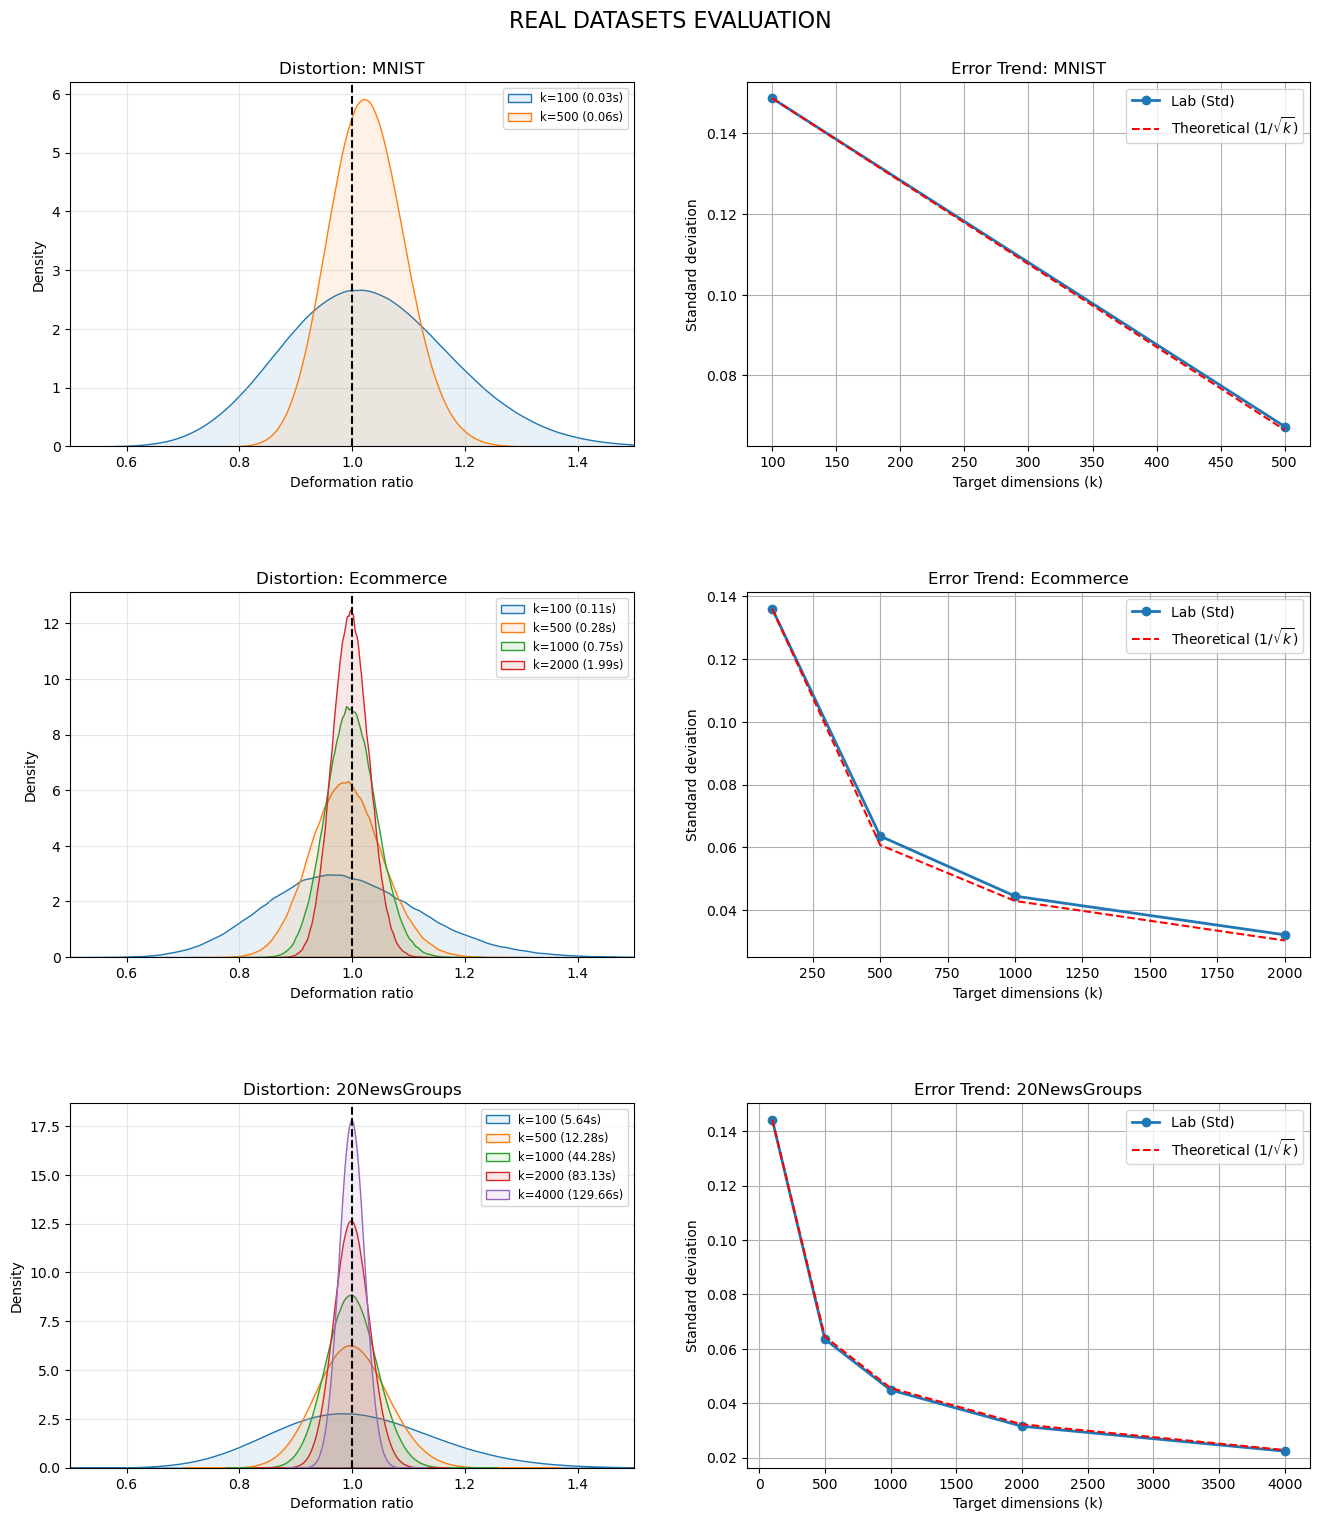

In [11]:
if __name__ == "__main__":
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle("REAL DATASETS EVALUATION", fontsize=16, y=0.92)

    def safe_sample(X, limit=5000):
        if X.shape[0] > limit:
            print(f"Data too large ({X.shape[0]} samples). Automatically select a random {limit} sample to calculate Benchmark...")
            indices = np.random.choice(X.shape[0], limit, replace=False)

            if hasattr(X, "toarray"): # sparse matrix (Ecommerce, News)
                return X[indices].toarray()
            else:
                return X[indices] # Numpy noraml array

        if hasattr(X, "toarray"):
            return X.toarray()
        return X

    # MNIST 
    try:
        if 'df_mnist' in globals():
            X_mnist_bench = safe_sample(df_mnist, limit=5000)

            res_mnist = benchmark_hyperparameter_k(X_mnist_bench, ax=axes[0, 0], dataset_name="MNIST")
            plot_error_trend(res_mnist, ax=axes[0, 1], dataset_name="MNIST")
        else:
            print("Do not load df_mnist")
    except Exception as e:
        print(f"Skip MNIST Error: {e}")

    # E-COMMERCE 
    try:
        if 'X_ecommerce' in globals():
            X_ecom_bench = safe_sample(X_ecommerce, limit=5000)
            res_ecom = benchmark_hyperparameter_k(X_ecom_bench, ax=axes[1, 0], dataset_name="Ecommerce")
            plot_error_trend(res_ecom, ax=axes[1, 1], dataset_name="Ecommerce")
        else:
            print("Do not X_ecommerce")
    except Exception as e:
         print(f"Skip Ecommerce Error: {e}")

    # 20 NEWSGROUPS 
    try:
        if 'X_high_dim' in globals():
            X_news_bench = safe_sample(X_high_dim, limit=5000)
            res_news = benchmark_hyperparameter_k(X_news_bench, ax=axes[2, 0], dataset_name="20NewsGroups")
            plot_error_trend(res_news, ax=axes[2, 1], dataset_name="20NewsGroups")
        else:
            print("Do not X_high_dim")
    except Exception as e:
        print(f"Skip Newsgroups Error: {e}")

    plt.show()